# Python for Data Science
### Big Data Toronto Master Class, June 12, 2012
### Nick Pogrebnyakov

## 1. Imports and setup

Import libraries and download the building occupancy detection dataset.

The dataset is here: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

It is described in more detail in this paper: https://www.sciencedirect.com/science/article/pii/S0378778815304357

The dataset contains measurements from various sensors inside buildings (light, temperature, humidity, CO<sub>2</sub>) along with whether the building was occupied or not (1/0).

First, import libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
import zipfile
import urllib
import shutil
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
useLocal = False  # use locally saved dataset, rather than download it from the internet

Next, download the dataset and extract data files.

In [2]:
if not useLocal:
    print('Downloading dataset...', end = '')
    # download the data: we're using the occupancy detection dataset from https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip", "occupancy.zip")
    print(' done.')

    # unzip the file
    with zipfile.ZipFile('occupancy.zip', 'r') as z:
        z.extractall('occupancy_data')

Use Pandas to read the datasets from CSV files into a Pandas DataFrame.

In [3]:
# get training and test datasets and put them into a Pandas dataframe
trainSet = pd.read_csv(os.path.join('occupancy_data', 'datatraining.txt'))
testSet = pd.read_csv(os.path.join('occupancy_data', 'datatest.txt'))

Remove the downloaded files.

In [4]:
if not useLocal:
    # clean up: remove downloaded files
    shutil.rmtree('occupancy_data')
    os.remove('occupancy.zip')

## 2. Explore the data

#### 2.1. Raw data

Examine the top 10 rows in the training dataset.

In [5]:
trainSet.head(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1
6,2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1
7,2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1
8,2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1
9,2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1
10,2015-02-04 18:00:00,23.075,27.1750,419.0,688.000000,0.004745,1


#### 2.2. Descriptive statistics

Show descriptive statistics of the training dataset.

In [6]:
trainSet.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


#### 2.3. Data histograms

Plot histograms of variable distributions.

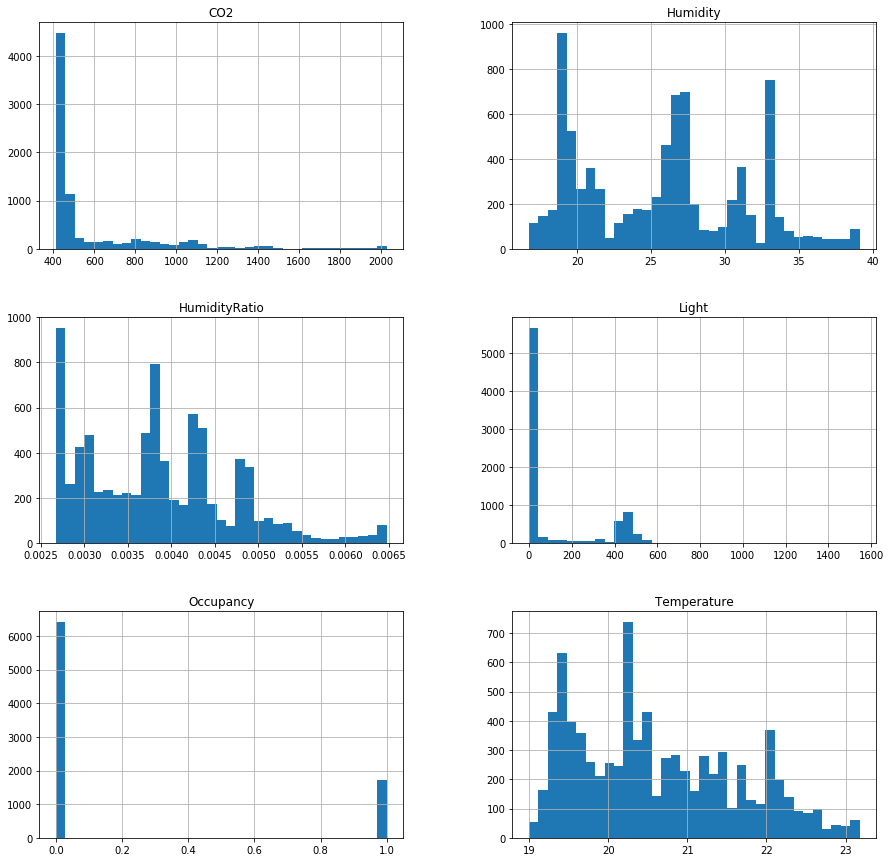

In [7]:
trainSet.hist(bins=35, figsize=(15, 15))
plt.show()

#### 2.4. Compare means of variables for occupied and vacant buildings

Create a "pivot table" that shows, for each variable, its mean value when the building is vacant (Occupancy == 0) and occupied (Occupancy == 1).

In [8]:
trainSet.pivot_table(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], index='Occupancy')

,CO2,Humidity,HumidityRatio,Light,Temperature
Occupancy,,,,,
0,490.320312,25.349685,0.003730,27.776442,20.334931
1,1037.704786,27.147938,0.004355,459.854347,21.673192


#### 2.5. Temperature by day of week

Look at mean temperatures in the building on every day of the week.

First, add dates of week to the dataset.

In [9]:
trainSet['DayOfWeek'] = pd.to_datetime(trainSet['date']).dt.weekday_name
trainSet.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,DayOfWeek
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,Wednesday
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,Wednesday
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,Wednesday
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,Wednesday
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,Wednesday


Next, create a pivot table of mean temperatures by day of week.

In [10]:
pivot = trainSet.pivot_table('Temperature', index='DayOfWeek')
pivot

,Temperature
DayOfWeek,
Friday,20.880500
Monday,20.498565
Saturday,20.576546
Sunday,19.510642
Thursday,21.469044
Tuesday,20.283957
Wednesday,21.765255


#### 2.6. Plot selected variables by occupancy

Plot light and temperature when the building is vacant (red dots) and occupied (blue dots).

Text(0,0.5,'Temperature')

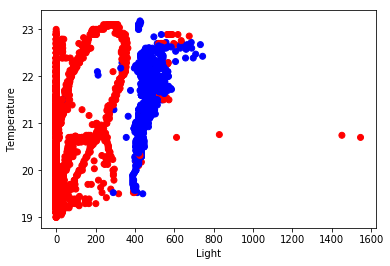

In [11]:
colors = np.array(['r', 'b'])
plt.scatter(trainSet['Light'], trainSet['Temperature'], c = colors[trainSet['Occupancy']])
plt.xlabel('Light')
plt.ylabel('Temperature')

## 3. Model: logistic regression

Create a `LogisticRegression()` classifier from `scikit-learn` and use it to predict building occupancy based on the features in the dataset.

#### 3.1. Convert data for the classifier

Convert the training and test sets from `DataFrame` to matrices: dependent variables, `x`, and independent variables, `y`.

In [12]:
# convert DataFrame with the training set to matrices
xTrain = trainSet[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
yTrain = trainSet[['Occupancy']]
# convert the dependent variable to 1-dimensional array: (length,) - needed for LogisticRegression()
yTrain = np.ravel(yTrain)

# repeat for the test set
xTest = testSet[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
yTest = testSet[['Occupancy']]
yTest = np.ravel(yTest)

#### 3.2. Run the classifier

In [13]:
clf = LogisticRegression()
clf.fit(xTrain, yTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 3.3. Evaluate results

Calculate accuracy score for predicted values.

In [14]:
yPred = clf.predict(xTest)
accuracy = accuracy_score(yTest, yPred)
print("Accuracy score:", accuracy)

Accuracy score: 0.9782363977485928
